# **Phase 2: Machine Learning Model Development**

The objective of this phase is to select and prototype suitable machine learning algorithms for predicting customer churn in a subscription-based telco service. This process involves evaluating various models to identify the most effective approach tailored to this specific churn prediction challenge.

## Initial Model Prototyping

Several models have been prototyped to assess their suitability and performance for the churn prediction task. Generally, these models can be built using standard libraries with minimal customization. However, if the dataset and preprocessing requirements vary significantly from one model to another, this can result in considerable development effort. In such cases, it is prudent to adhere to theoretical concepts by selecting a few ML algorithms well-suited for the task and limiting the number of models tested. For this project, the following models were prototyped:

- [x] **Logistic Regression Model Prototyping**
- [x] **Random Forest Model Prototyping**
- [x] **XGBoost Model Prototyping**
- [x] **DNN (Deep Neural Network) Model Prototyping**
- [x] **CNN (Convolutional Neural Network) for Tabular Data Prototyping**


In [ ]:
# Installing the required Python packages with minimal output
!pip install --quiet xgboost tensorflow 

In [17]:
import ast
import glob
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.math import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc
)

import matplotlib.pyplot as plt

In [18]:
# Load the dataset
data = np.load('../data/dataset.npz')

# Extract the arrays for training, validation, and testing
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

## Evaluation Metrics

Considering the dataset has significant skew and imbalance towards the negative class, several imbalance-aware evaluation metrics were utilized to gauge each model's performance. These metrics include recall, Precision-Recall AUC, F1 Score, and the confusion matrix. Evaluating these metrics provides a comprehensive view of each model’s strengths and weaknesses in predicting customer churn. Based on these metrics, the best models will be selected for further refinement using Vertex AI Vizier for hyperparameter tuning.

### Overview of Model Evaluation Toolkit

The three functions listed are crucial tools in analyzing and interpreting the results of machine learning models for the telco customer churn prediction task. Each function serves a specific role in the evaluation and visualization process, enhancing the comprehensiveness of the analysis.

#### 1. `evaluate_model`
**Purpose**: This function computes a variety of performance metrics which are essential for assessing the effectiveness of a predictive model. 
- **Metrics Calculated**:
  - **Confusion Matrix**: This matrix presents the counts of true positive, true negative, false positive, and false negative predictions, providing a clear picture of model accuracy and type I/II errors.
  - **Precision**: Indicates the proportion of positive identifications that were actually correct.
  - **Recall**: Measures the proportion of actual positives that were correctly identified.
  - **Accuracy**: Reflects the overall correctness of the model across all predictions.
  - **F1-Score**: Combines precision and recall into a single metric by taking their harmonic mean, useful in scenarios of class imbalance.
  - **AUC-ROC**: Represents the area under the receiver operating characteristic curve, summarizing the trade-off between true positive rate and false positive rate.
  - **AUC-PR**: Represents the area under the precision-recall curve, useful for evaluating models on imbalanced datasets.

#### 2. `print_evaluation`
**Purpose**: This function outputs the evaluation metrics calculated by the `evaluate_model` function in a clear and structured format, thereby enabling easy interpretation and comparison across models.
- **Functionality**: It iteratively prints each metric for a specific model, providing a textual summary that complements the quantitative analysis. A new line is added between model evaluations for better readability.

#### 3. `plot_auc_curves`
**Purpose**: Visualizes two important curves, the ROC and Precision-Recall curves, for multiple models, facilitating visual comparison of model performance in classifying the positive class in the context of variable false positive rates and recall levels.
- **Functionality**:
  - **ROC Curve**: Plots the true positive rate against the false positive rate at various threshold settings, highlighted with an AUC score.
  - **Precision-Recall Curve**: Plots recall against precision for different probability thresholds, also highlighted with an AUC score.
  - This visualization is particularly useful when working with imbalanced datasets, as it allows for a detailed understanding of how well the model distinguishes between classes across different thresholds.

These functions together form a comprehensive toolkit for evaluating, interpreting, and presenting the performance of machine learning models in predicting customer churn. By combining numerical metrics with visual aids, they allow for a nuanced assessment that can guide further model tuning and selection processes.

In [3]:
def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    """
    Evaluate a model on various performance metrics.
    
    Parameters:
    - model_name: str. Name of the model being evaluated.
    - y_true: array-like. True labels.
    - y_pred: array-like. Predicted labels.
    - y_pred_proba: array-like (default None). Predicted probabilities for the positive class.
    
    Returns:
    - A dictionary with metric names as keys and their corresponding values.
    """
    metrics = {
        'Model': model_name,
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A',
        'AUC-PR': average_precision_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A',
    }
    
    return metrics

In [4]:
def print_evaluation(metrics):
    """
    Prints the evaluation metrics from the evaluate_model function.
    """
    for key, value in metrics.items():
        if key != 'Model':
            print(f"{key}: {value}")
        else:
            print(f"{value} Evaluation")
    print("\n")  # New line for better readability between model evaluations

In [5]:
def plot_auc_curves(model_predictions, y_test):
    """
    Plot AUC-ROC and AUC-PR curves for multiple models.
    
    Parameters:
    - model_predictions: dict. A dictionary where keys are model names and 
                         values are dictionaries with keys 'y_pred_proba' and optionally 'label'.
    - y_test: array-like. True labels.
    """
    plt.figure(figsize=(14, 6))
    
    for model_name, preds in model_predictions.items():
        y_pred_proba = preds.get('y_pred_proba')
        label = preds.get('label', model_name)  # Use model name as label if not provided
        
        # AUC-ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, linewidth=2, label=f'{label} AUC-ROC = {roc_auc:.2f}')
        
        # AUC-PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, linewidth=2, label=f'{label} AUC-PR = {pr_auc:.2f}')
    
    # Finalizing AUC-ROC plot
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
    plt.scatter(0, 1, color='red', label='Perfect Performance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Finalizing AUC-PR plot
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [1, 1], color='red', linestyle='--', label='Perfect Performance')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

##  Logistic Regression Model Configuration and Training

#### Configuration
- **`max_iter=1000`**: Ensures convergence for complex datasets.
- **`class_weight='balanced'`**: Addresses class imbalance by adjusting weights inversely to class frequencies, promoting fairness in model learning.

#### Predictions
Outputs binary class predictions and their associated probabilities, enhancing decision-making with insights into prediction confidence. The model leverages `predict_proba` for probability estimations, crucial for evaluating churn likelihood in the test dataset.

In [6]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [7]:
lr_metrics = evaluate_model("Logistic Regression", y_test, y_pred_lr, y_pred_proba_lr)
print_evaluation(lr_metrics)

Logistic Regression Evaluation
Confusion Matrix: [[353 152]
 [ 41 158]]
Precision: 0.5096774193548387
Recall: 0.7939698492462312
Accuracy: 0.7258522727272727
F1-Score: 0.6208251473477406
AUC-ROC: 0.8139608935767948
AUC-PR: 0.6479686897345432




## RandomForest Classifier Model Configuration and Training

### Adjusting for Class Imbalance
The RandomForest model is configured with `class_weight='balanced'` to equitably address class discrepancies. This parameter helps in adjusting the weights inversely relative to class frequencies in the input data, ensuring the model does not favor the majority class disproportionately.

### Predictions and Probabilities
The model provides both class predictions and probability estimates for the positive class (churn). The probabilities are crucial for detailed performance evaluation, particularly for AUC calculations, enhancing the understanding of model effectiveness in predicting customer churn.

In [9]:
# Adjusting for class imbalance
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions using probabilities for AUC calculations
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [10]:
rf_metrics = evaluate_model("Random Forest", y_test, y_pred_rf, y_pred_proba_rf)
print_evaluation(rf_metrics)

Random Forest Evaluation
Confusion Matrix: [[445  60]
 [111  88]]
Precision: 0.5945945945945946
Recall: 0.44221105527638194
Accuracy: 0.7571022727272727
F1-Score: 0.5072046109510087
AUC-ROC: 0.800796059505448
AUC-PR: 0.6136053928641519




## XGBoost Model Configuration and Training

### Handling Class Imbalance
The XGBoost model utilizes the `scale_pos_weight` parameter calculated as the ratio of negative to positive instances in the training set. This approach helps counteract the imbalance by giving more importance to the minority class during training.

### Data Optimization
Data is formatted into DMatrix objects, a data structure optimized for XGBoost, enhancing both efficiency and processing speed during training.

### Model Parameters
Key parameters configured for the XGBoost model include:
- `max_depth`: Control complexity.
- `eta`: Learning rate.
- `lambda` and `alpha`: Regularization terms to prevent overfitting.
- `subsample` and `colsample_bytree`: Subsampling of the dataset and features.
- `objective`: Specific to binary classification.
- `eval_metric`: Evaluation with AUCPR (Area under the Precision-Recall Curve) to focus on the performance concerning the minority class.

### Training Process
The model undergoes training over 300 epochs with early stopping implemented if performance on a validation dataset does not improve for five consecutive epochs. This prevents overfitting and unnecessary computations.

### Predictions
Post-training, the model predicts on the test set, generating probability outputs used to derive binary class predictions based on a threshold of 0.5. This threshold balancing act is crucial for practical deployment contexts where precision and recall weights significantly impact business outcomes.

In [27]:
num_negative = np.sum(y_train == 0)
num_positive = np.sum(y_train == 1)
scale_pos_weight = num_negative / num_positive

# Convert the datasets into DMatrix objects, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 7,
    'eta': 0.09,
    'lambda': 8,
    'alpha': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'scale_pos_weight': scale_pos_weight,
}

epochs = 300  # Number of epochs

# Train the model
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=epochs, evals=evals, early_stopping_rounds=5)


# Predictions on test set
y_pred_xgb = model.predict(dtest)
y_pred_binary_xgb = (y_pred_xgb > 0.5).astype(int)


[0]	train-aucpr:0.62763	eval-aucpr:0.56101
[1]	train-aucpr:0.68960	eval-aucpr:0.59273
[2]	train-aucpr:0.70392	eval-aucpr:0.63195
[3]	train-aucpr:0.70990	eval-aucpr:0.63993
[4]	train-aucpr:0.71481	eval-aucpr:0.64569
[5]	train-aucpr:0.71711	eval-aucpr:0.64779
[6]	train-aucpr:0.72434	eval-aucpr:0.64462
[7]	train-aucpr:0.73583	eval-aucpr:0.62960
[8]	train-aucpr:0.74266	eval-aucpr:0.64674
[9]	train-aucpr:0.74638	eval-aucpr:0.64762
[10]	train-aucpr:0.75369	eval-aucpr:0.64801
[11]	train-aucpr:0.75922	eval-aucpr:0.64865
[12]	train-aucpr:0.76608	eval-aucpr:0.64499
[13]	train-aucpr:0.77266	eval-aucpr:0.65107
[14]	train-aucpr:0.77983	eval-aucpr:0.65017
[15]	train-aucpr:0.79065	eval-aucpr:0.64957
[16]	train-aucpr:0.79406	eval-aucpr:0.64474
[17]	train-aucpr:0.79930	eval-aucpr:0.64611


In [28]:
xgb_metrics = evaluate_model("XGBoost", y_test,y_pred_binary_xgb, y_pred_xgb)
print_evaluation(xgb_metrics)

XGBoost Evaluation
Confusion Matrix: [[367 138]
 [ 55 144]]
Precision: 0.5106382978723404
Recall: 0.7236180904522613
Accuracy: 0.7258522727272727
F1-Score: 0.5987525987525988
AUC-ROC: 0.8117120254739042
AUC-PR: 0.6485996962965966




## Deep Neural Network (DNN) Model Configuration and Training

#### Managing Class Imbalance
Class weights are dynamically computed based on the class distribution in the training data, ensuring balanced influence during training. These weights help compensate for the imbalance by adjusting the loss function, giving more importance to underrepresented classes.

#### Model Architecture
The DNN model is structured with several layers to manage complexity and prevent overfitting:
- **Dense Layers with ReLU Activation**: For feature transformation and non-linear mapping.
- **Dropout Layers (0.5 rate)**: Introduced after each Dense layer except the output to reduce overfitting by randomly setting input units to 0 during training.
- **Output Layer with Sigmoid Activation**: Appropriate for binary classification, squashing the output between 0 and 1.

#### Compilation and Callbacks
- **Optimizer**: 'adam' for efficient stochastic gradient descent.
- **Loss Function**: 'binary_crossentropy', suitable for binary classification problems.
- **Metrics**: 'accuracy' to track training performance.
- **Callbacks**:
  - **EarlyStopping**: Monitors validation loss, halting training when improvement stalls, ensuring resource efficiency and model optimization.
  - **ReduceLROnPlateau**: Adjusts the learning rate when the validation loss plateaus, facilitating finer convergence by reducing the learning rate incrementally.

#### Training Process
The model is trained using class weights to address class imbalance, with a validation dataset to monitor performance and avoid overfitting:
- **Epochs**: Set to 100, allowing sufficient iterations for the network to learn from the data.
- **Batch Size**: 64, balancing computation speed and model update granularity.
- **Class Weights**: Applied to adjust the loss function dynamically during training, emphasizing the minority class.

#### Evaluation
Post-training, the DNN model is evaluated on the test dataset:
- **Loss and Accuracy**: Provides a quantitative measure of model performance, indicating how well the model predicts unseen data.

This setup leverages modern deep learning techniques and training processes to develop a robust model capable of predicting customer churn effectively, accounting for data imbalances inherent in real-world scenarios.

In [13]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define the DNN model with dropout layers
dnn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),  # Dropout layer after the first dense layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer after the second dense layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer after the second dense layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# Train the DNN model with early stopping and adaptive learning rate
# Use the class weights in model training
history = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict  # Apply class weights
)


# Evaluate the DNN model
dnn_eval = dnn_model.evaluate(X_test, y_test)
print(f'DNN Test Loss: {dnn_eval[0]:.5f}')
print(f'DNN Test Accuracy: {dnn_eval[1]:.5f}')


Metal device set to: Apple M1 Pro


2024-04-12 00:41:56.375129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 00:41:56.375474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-04-12 00:41:56.880155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 11ms/step - loss: 0.6015 - accuracy: 0.7004 - val_loss: 0.4945 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 2/100
 1/88 [..............................] - ETA: 0s - loss: 0.4486 - accuracy: 0.7969

2024-04-12 00:41:58.001913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 6ms/step - loss: 0.5300 - accuracy: 0.7355 - val_loss: 0.4876 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 0.5197 - accuracy: 0.7394 - val_loss: 0.5070 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4985 - accuracy: 0.7415 - val_loss: 0.4916 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 1s 6ms/step - loss: 0.5038 - accuracy: 0.7415 - val_loss: 0.4777 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4911 - accuracy: 0.7531 - val_loss: 0.4849 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4911 - accuracy: 0.7532 - val_loss: 0.4927 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 8/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4869 - accura

In [14]:
# Predictions on test set
y_pred_dnn = dnn_model.predict(X_test)
y_pred_dnn_binary = (y_pred_dnn > 0.5).astype(int)

dnn_metrics = evaluate_model("DNN", y_test, y_pred_dnn_binary, y_pred_dnn)
print_evaluation(dnn_metrics)

22/22 [==============================] - 0s 2ms/step
DNN Evaluation
Confusion Matrix: [[350 155]
 [ 43 156]]
Precision: 0.5016077170418006
Recall: 0.7839195979899497
Accuracy: 0.71875
F1-Score: 0.6117647058823529
AUC-ROC: 0.8125578386984427
AUC-PR: 0.6368661318545197




2024-04-12 00:42:06.688069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## CNN Model for Tabular Data: Configuration and Training

### Data Preprocessing
- **Reshaping**: Data is reshaped to a three-dimensional format (samples, features, 1) to fit the input requirements of a Convolutional Neural Network (CNN) handling 1D convolutions.

### Class Weight Calculation
- **Balancing**: Class weights are computed and applied to balance the dataset, counteracting the effects of class imbalance by adjusting how the model perceives class importance during training.

### Model Architecture
- **Conv1D Layers**: Designed to process sequence data, capturing local feature patterns with a reduced number of parameters.
- **MaxPooling1D**: Reduces dimensionality, enhancing the detection of relevant features.
- **Flatten Layer**: Transforms the pooled feature map into a single column, preparing it for the dense layer.
- **Dense and Dropout Layers**: A Dense layer with ReLU activation followed by a Dropout layer (rate of 0.5) to prevent overfitting by randomly omitting units during training.
- **Output Layer**: Uses a sigmoid activation function suitable for binary classification tasks.

### Compilation and Training Strategy
- **Optimizer**: 'adam' — Efficiently handles sparse gradients on noisy problems.
- **Loss Function**: 'binary_crossentropy' — Appropriate for binary classification problems.
- **Callbacks**:
  - **EarlyStopping**: Stops training when validation loss ceases to decrease, preventing overfitting.
  - **ReduceLROnPlateau**: Reduces learning rate when a metric has stopped improving, aiding in reaching the global minimum more efficiently.

### Training Execution
- The model is trained with class weights to emphasize learning from underrepresented classes.
- **Epochs and Batch Size**: Configured for 100 epochs with a batch size of 64, balancing speed and performance.

### Model Evaluation
- Post-training, the model's performance is assessed on the test dataset to evaluate loss and accuracy, providing insights into generalizability beyond the training data.

This CNN model setup, combining innovative architecture with precise training techniques, aims to robustly predict customer churn while accounting for potential biases introduced by class imbalances.

In [15]:
# Reshape data: (number of samples, number of features, 1)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


def create_cnn_tabular_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_tabular_model((X_train.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')


history = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict  # Apply class weights here
)

# Evaluate the CNN model
cnn_eval = cnn_model.evaluate(X_test_reshaped, y_test)
print(f'CNN Test Loss: {cnn_eval[0]:.5f}')
print(f'CNN Test Accuracy: {cnn_eval[1]:.5f}')

Epoch 1/100


2024-04-12 00:42:07.054764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7152

2024-04-12 00:42:08.178245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 11ms/step - loss: 0.5396 - accuracy: 0.7152 - val_loss: 0.5441 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4965 - accuracy: 0.7344 - val_loss: 0.5329 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4905 - accuracy: 0.7442 - val_loss: 0.5064 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4856 - accuracy: 0.7504 - val_loss: 0.5127 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4867 - accuracy: 0.7445 - val_loss: 0.4880 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4829 - accuracy: 0.7557 - val_loss: 0.4551 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4847 - accur

In [16]:
# Predictions for further metrics calculation
y_pred_cnn = cnn_model.predict(X_test_reshaped)
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)

cnn_metrics = evaluate_model("CNN", y_test, y_pred_cnn_binary, y_pred_cnn)
print_evaluation(cnn_metrics)

22/22 [==============================] - 0s 2ms/step
CNN Evaluation
Confusion Matrix: [[357 148]
 [ 50 149]]
Precision: 0.5016835016835017
Recall: 0.7487437185929648
Accuracy: 0.71875
F1-Score: 0.6008064516129032
AUC-ROC: 0.8132643415095278
AUC-PR: 0.6458337019217688




2024-04-12 00:42:17.829152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Model Performance Comparison

After evaluating various machine learning models on the customer churn prediction dataset, the performance metrics have been aggregated into a single DataFrame for clear and concise comparison. The following metrics for each model are outlined:

- **Confusion Matrix**: Displays the number of true positives, true negatives, false positives, and false negatives.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ability of the model to find all the relevant cases (true positives).
- **Accuracy**: Measures the ratio of correctly predicted observations (both true positives and true negatives) to the total observations.
- **F1-Score**: Weighted average of Precision and Recall, useful for imbalanced datasets.
- **AUC-ROC**: Represents how well the model is capable of distinguishing between classes.
- **AUC-PR**: Focuses on the precision-recall balance, particularly useful in the context of an imbalanced dataset.

The DataFrame `metrics_df` offers a straightforward method to assess and analyze the performance across different models, facilitating decisions on model selection for deployment based on specific organizational goals and threshold preferences regarding various evaluation metrics.

In [17]:
# Assuming metrics have been collected for all models into a list of dictionaries
all_metrics = [lr_metrics, xgb_metrics, rf_metrics, dnn_metrics, cnn_metrics]

# Convert to DataFrame for easy viewing
metrics_df = pd.DataFrame(all_metrics)

# Display the DataFrame
metrics_df

,Model,Confusion Matrix,Precision,Recall,Accuracy,F1-Score,AUC-ROC,AUC-PR
0,Logistic Regression,"[[353, 152], [41, 158]]",0.509677,0.793970,0.725852,0.620825,0.813961,0.647969
1,XGBoost,"[[351, 154], [47, 152]]",0.496732,0.763819,0.714489,0.601980,0.812797,0.656874
2,Random Forest,"[[445, 60], [111, 88]]",0.594595,0.442211,0.757102,0.507205,0.800796,0.613605
3,DNN,"[[350, 155], [43, 156]]",0.501608,0.783920,0.718750,0.611765,0.812558,0.636866
4,CNN,"[[357, 148], [50, 149]]",0.501684,0.748744,0.718750,0.600806,0.813264,0.645834


### Plotting AUC Curves for Model Evaluation

The AUC (Area Under the Curve) plots are crucial for visually assessing the performance of various predictive models in terms of their ability to distinguish between the classes (i.e., customers who will churn versus those who will not). We focus on two types of AUC curves:

- **ROC Curve (Receiver Operating Characteristic)**: Plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. It summarizes the trade-off between true positive rate and false positive rate.
- **Precision-Recall Curve**: Especially valuable in datasets with class imbalance. It focuses on the relationship between recall (sensitivity) and precision for the positive (minority) class.

#### Implementation
The `plot_auc_curves` function takes a dictionary of model predictions and the true labels (`y_test`). Each model's predictions include probability scores of the positive class, essential for generating ROC and Precision-Recall curves.

#### Usage
The `model_predictions` dictionary should map model names to their respective predictions. Here, it includes predictions from models like Logistic Regression, XGBoost, Random Forest, DNN, and CNN.

The subsequent execution of the `plot_auc_curves` function will generate:
- Two plots per model: one for the ROC curve and another for the Precision-Recall curve.
- Metrics like AUC-ROC and AUC-PR are calculated to quantify the models' effectiveness in class separation and positive class prediction accuracy, respectively.

These visual comparisons help in identifying the models that perform best in predicting churn under different operational conditions and user thresholds, thereby assisting in making informed decisions regarding the deployment of predictive models in production environments.

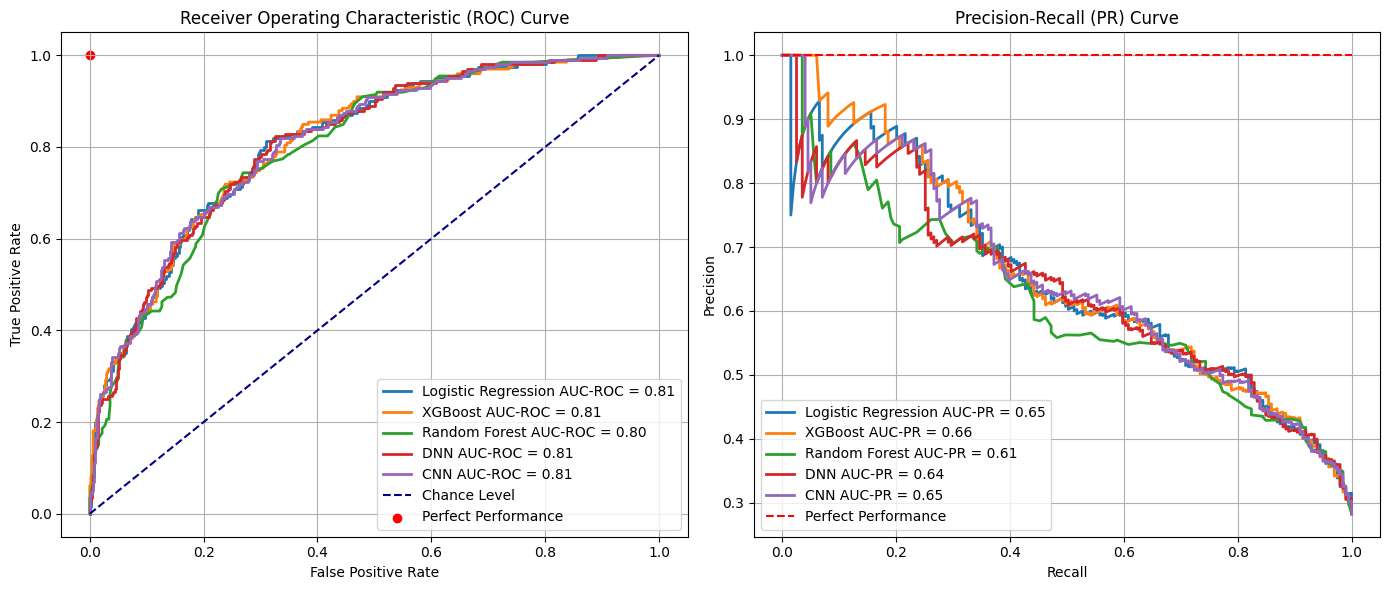

In [18]:
model_predictions = {
    'Logistic Regression': {'y_pred_proba': y_pred_proba_lr},
    'XGBoost': {'y_pred_proba': y_pred_xgb},
    'Random Forest': {'y_pred_proba': y_pred_proba_rf},
    'DNN': {'y_pred_proba': y_pred_dnn},
    'CNN': {'y_pred_proba': y_pred_cnn},
    # Add more models if you have them
}

plot_auc_curves(model_predictions, y_test)


## ML Algorithm Selection

### Justification for Selecting XGBoost

The choice of XGBoost as the preferred model for further development and hyperparameter tuning in this churn prediction scenario is rooted in the critical business context of balancing costs related to customer retention and loss. The selected metric and model align with the primary goal of optimizing retention strategies without excessively incurring costs through indiscriminate discounts and promos. Here's why this decision holds strategic advantage:

1. **Cost-Benefit Trade-off**: In the telecom sector, the costs associated with losing a customer significantly impact revenue. Equally, retaining a customer through discounts and promotions incurs expenses. XGBoost provides a balanced approach between precision and recall, making it a suitable choice to tackle the dual challenge of minimizing false positives (unnecessary discounts to customers not at churn risk) and false negatives (failing to identify customers at churn risk).

2. **Business Objective Alignment**: The telecommunications environment demands a model that can adapt to the intricate balance between retaining a potentially churning customer and the costs of potential retention strategies (like offering discounts). XGBoost, with its relatively higher AUC-PR, suggests it is the best among the tested models at finding this balance, offering an effective means to manage the trade-offs at stake.

3. **Practical Implications**: The practicality of using XGBoost evolves from its strength in handling imbalanced datasets effectively and its robustness in tuning to optimize for specific results—here, balancing precision and recall. It's pivotal in scenarios where an incorrect target optimization can lead to practical deployment failures.

4. **Flexibility and Scalability**: The nature of XGBoost allows for extensive hyperparameter tuning possibilities. This adaptability is essential in optionally shifting focus more towards recall or precision as business needs and cost dynamics evolve, ensuring that the model remains relevant and aligned with strategic objectives.

In summary, XGBoost's balanced performance across crucial metrics supports its selection. It upholds the business's need to maintain a rational and cost-effective equilibrium between identifying actual churn risks and managing retention costs, embodying a strategic asset in the predictive modeling of customer behaviors.

### **Special Note on Selecting the Optimal Evaluation Metric: The model should be optimized based on business context and cost dynamics.**

If the cost of losing a customer significantly outweighs the cost of offering promotions or discounts, models with a higher recall such as Logistic Regression or the DNN might be preferable. These models are more likely to capture a higher number of customers who might churn (reducing false negatives), even at the expense of occasionally targeting customers who would not have churned (increasing false positives).

# Hyperparameter Tuning on Google Cloud Vertex AI

Google Cloud Vertex AI offers robust capabilities for hyperparameter tuning, making it an excellent choice for optimizing machine learning models. This platform facilitates the comprehensive exploration of the parameter space spanning numerous trials, thereby enhancing model performance efficiently. The process leverages Vertex AI's managed service to run multiple trials concurrently, which accelerates the identification of the best model configurations. 


### Selecting Objective function for Hyperparameter Optimization

In the Vertex AI  Hyperparameter Optimization process, I have chosen the area under the Precision-Recall Curve as the objective function. The plan is to maximize this value by identifying the hyperparameters that can enhance it. This decision is grounded by the assumptions about the business context, which involve finding the optimal balance and trade-off between the cost of losing customers versus the cost of providing discounts and promotions. As previously mentioned, if the cost of losing customers exceeds the cost of offering promotions and discounts, we should consider alternative objective functions, such as recall.

### Hyperparameter Tuning Job Application

In our workflow, setting the hyperparameters like `max_depth`, `eta`, `lambda`, etc., are crucial for XGBoost's performance. The script provided defines a training job on Vertex AI, where these hyperparameters are dynamically adjusted across trials to achieve the best predictive accuracy. Using functions like `hypertune.HyperTune()`, the script reports performance metrics back to Vertex AI, allowing it to intelligently adjust parameters for subsequent trials. This systematic and automated approach significantly reduces the time and complexity involved in model tuning while systematically tracking and improving performance metrics.

The Python script designated for execution on Google's Vertex AI platform, is engineered for the purpose of hyperparameter tuning using XGBoost within a machine learning pipeline. Below is a summarized breakdown of its core functionalities:

1. **Data Handling**:
   - The script integrates functionality to load numerical datasets directly from Google Cloud Storage (GCS), facilitating operations on cloud-hosted data. The data is pulled in `.npz` format (a common format for storing large arrays).
   - Utility functions are also provided to upload results back to GCS, supporting an end-to-end workflow in a cloud environment.

2. **Argument Parsing**:
   - Command-line arguments are parsed to receive configurations externally, making the script flexible to different runs without changes in the code. This includes receiving bucket names, file paths, and values for various tuning parameters.

3. **Model Training with XGBoost**:
   - The core of the script concerns training an XGBoost model. It handles typical machine learning tasks such as data splitting into train, validation, and test sets, setting up model parameters, and training with early stopping to prevent overfitting.
   - Model parameters are dynamically set based on the parsed command-line inputs, and they include depth of trees, learning rate, regularization terms, and subsampling options among others. The goal is to maximize precision-recall area under curve (specifically tuned through a provided hyperparameter tuning service).

4. **Model Evaluation and Output**:
   - After training, the model is evaluated against a test set. Metrics such as precision, recall, F1 score, ROC-AUC, and especially AUC-PR (for which it's being tuned) are computed.
   - The evaluation results and hyperparameters are documented in generated metadata. 

5. **Integration with HyperTune**:
   - The script uses `hypertune` to report the primary metric (AUC-PR in this setup) back to the hyperparamater tuning service of Vertex AI. This feedback mechanism allows Vertex AI to analyze the metric and adjust hyperparameters in subsequent trials intelligently.

6. **Metadata Management**:
   - Generated evaluation metrics, hyperparameters and the trained model are saved locally and then uploaded to specified locations in GCS. 
   - In the script, a Unix timestamp is utilized to generate a unique identifier for each training run, ensuring each set of results, including the corresponding metadata and model outputs, is distinctly timestamped. 
   - This timestamp is then embedded in the filenames of the metadata and model before they are uploaded to Google Cloud Storage (GCS), aiding in the organization and retrieval of results over multiple experimental runs.

This script is a comprehensive implementation for training and evaluating an XGBoost model in a cloud environment, leveraging automated hyperparameter tuning for optimal model performance. It is designed to be robust, adaptable, and fully integrated with cloud-native services for machine learning tasks.

In [23]:
%%writefile ../vertex-ai/tune.py
import xgboost as xgb
import numpy as np
import pandas as pd
import hypertune
import io
import argparse
from google.cloud import storage
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    accuracy_score, f1_score, roc_auc_score, average_precision_score
)
import time


# Function to load npz file from Google Cloud Storag
def load_npz_from_gcs(bucket_name, file_path):
    """
    Load a numpy NpzFile object from a file in Google Cloud Storage.

    Parameters:
    - bucket_name: str. The name of the GCS bucket where the file is stored.
    - file_path: str. The path to the file in the GCS bucket.

    Returns:
    - np.load(data_file): NpzFile. The data loaded from the file.
    """
    storage_client = storage.Client()  # Create a client to access the Google Cloud Storage service.
    bucket = storage_client.get_bucket(bucket_name)  # Create a bucket object for the specified bucket.
    blob = bucket.blob(file_path)  # Create a blob object for the specified file path.
    data_bytes = blob.download_as_bytes()  # Download the contents of the blob into memory.
    data_file = io.BytesIO(data_bytes)  # Use BytesIO to create a file-like object from the bytes data, which numpy can read from.
    return np.load(data_file)   # return the data as a numpy NpzFile object.


# Function to upload a file to Google Cloud Storage
def upload_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """
    Upload a file to Google Cloud Storage.

    Parameters:
    - bucket_name: str. The name of the GCS bucket where the file will be stored.
    - source_file_name: str. The path to the file on the local system.
    - destination_blob_name: str. The path where the file will be stored in the GCS bucket.
    """
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(f"File {source_file_name} uploaded to {destination_blob_name}.")


# Function to parse command line arguments
def parse_args():
    """
    Parse command line arguments.

    Returns:
    - args: Namespace. The parsed command line arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--bucket_name', help='Name of the GCS bucket', required=True)
    parser.add_argument('--file_path', help='Path to data', required=True)
    parser.add_argument('--max_depth', type=int, default=6)
    parser.add_argument('--eta', type=float, default=0.1)
    parser.add_argument('--lambda_value', type=float, default=1)
    parser.add_argument('--alpha', type=float, default=0.5)
    parser.add_argument('--subsample', type=float, default=0.8)
    parser.add_argument('--colsample_bytree', type=float, default=0.8)
    return parser.parse_args()


# Function to manage model metadata
def generate_model_metadata(timestamp, y_true, y_pred, y_pred_proba=None, hyperparameters=None):
    """
    Generate metadata for a model, including various performance metrics and hyperparameters.

    Parameters:
    - timestamp: str. Unix timestamp.
    - y_true: array-like. True labels.
    - y_pred: array-like. Predicted labels.
    - y_pred_proba: array-like (default None). Predicted probabilities for the positive class.
    - hyperparameters: dict (default None). Hyperparameters of the model.

    Returns:
    - metadata: dict. A dictionary with metric names as keys and their corresponding values, as well as the model's hyperparameters.
    """
    metadata = {
        'Unix Time': timestamp,
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A',
        'AUC-PR': average_precision_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A',
    }

    if hyperparameters is not None:
        metadata.update(hyperparameters)

    return metadata


# Function to print the evaluation metrics
def print_evaluation(metrics):
    """
    Prints the evaluation metrics from the evaluate_model function.

    Parameters:
    - metrics: dict. The metrics to print.
    """
    for key, value in metrics.items():
        if key != 'Model':
            print(f"{key}: {value}")
        else:
            print(f"{value} Evaluation")
    print("\n")  # New line for better readability between model evaluations


# Main function
def main():
    """
    Main function to run the script.
    """
    args = parse_args()
    data = load_npz_from_gcs(args.bucket_name, args.file_path)

    # Extract the arrays for training, validation, and testing
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    X_test = data['X_test']
    y_test = data['y_test']

    num_negative = np.sum(y_train == 0)
    num_positive = np.sum(y_train == 1)
    scale_pos_weight = num_negative / num_positive

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'lambda': args.lambda_value,
        'alpha': args.alpha,
        'subsample': args.subsample,
        'colsample_bytree': args.colsample_bytree,
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'scale_pos_weight': scale_pos_weight,
    }

    epochs = 300  # Number of epochs

    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrain, epochs, evals, early_stopping_rounds=5)
    y_pred = model.predict(dtest)
    y_pred_binary = (y_pred > 0.5).astype(int)

    unix_timestamp = time.time()
    unix_timestamp_str = str(unix_timestamp).replace('.', '')

    # Evaluate the model
    xgb_metadata = generate_model_metadata(unix_timestamp, y_test, y_pred_binary, y_pred, params)
    print_evaluation(xgb_metadata)

    # Report the RMSE to hyperparameter tuning service
    hpt = hypertune.HyperTune()
    hpt.report_hyperparameter_tuning_metric(
        hyperparameter_metric_tag='acupr',
        metric_value=xgb_metadata['AUC-PR'],
        global_step=epochs
    )

    # Assuming metrics have been collected for all models into a list of dictionaries
    all_metrics = [xgb_metadata]

    # Convert to DataFrame for easy viewing
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(f'xgb_metadata{unix_timestamp_str}.csv', index=False)

    # After training and saving the model...
    model.save_model(f'xgboost_model{unix_timestamp_str}.json')

    # GCS path for the model and Metadata
    gcs_model_path = f'model/xgboost_model{unix_timestamp_str}.json'
    gcs_metrices_path = f'metadata/xgb_metadata{unix_timestamp_str}.csv'

    # Upload the model and Metadata to GCS
    upload_to_gcs(args.bucket_name, f'xgboost_model{unix_timestamp_str}.json', gcs_model_path)
    upload_to_gcs(args.bucket_name, f'xgb_metadata{unix_timestamp_str}.csv', gcs_metrices_path)


if __name__ == '__main__':
    main()


Overwriting ../vertex-ai/tune.py


### Write Dockerfile and Build the Custom Container



In [28]:
%%writefile ../vertex-ai/Dockerfile

FROM asia-docker.pkg.dev/vertex-ai/training/xgboost-cpu.1-6:latest

WORKDIR /

# Copies the trainer code to the Docker image.
COPY ../vertex-ai/tune.py /trainer
COPY ../vertex-ai/hptuning_config.yaml /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.tune"]

Writing ../vertex-ai/Dockerfile


### Hyperparameter Tuning Job Configuration File  

This configuration file defines the setup for a hyperparameter tuning job performed using Vertex AI. Let's briefly discuss the chosen hyperparameters and their ranges, followed by an explanation of the `trialJobSpec`.

1. **max_depth**: 
   - Range: 3 to 50
   - This parameter controls the maximum depth of the trees. Lower values prevent overfitting but might underfit, while higher values might capture more complex patterns but can overfit.

2. **eta** (learning rate):
   - Range: 0.01 to 0.3
   - This affects the step size at each iteration while moving toward a minimum of a loss function. A smaller learning rate needs more boosting rounds, potentially improving the model by making it robust against overfitting, while a larger rate might speed up the computation.

3. **lambda_value** (L2 regularization term):
   - Range: 0.0 to 10.0
   - Helps handle the model's complexity by introducing a penalty term for the size of weights. A larger lambda enables more robust regularization.

4. **alpha** (L1 regularization term):
   - Range: 0.0 to 1.0
   - Similar to lambda but encourages sparsity, thus impacting feature selection by assigning some feature coefficients to zero under certain conditions.

5. **subsample**:
   - Range: 0.5 to 1.0
   - Determines the fraction of the training data to be randomly sampled for each tree. Lower values can make the algorithm faster and prevent overfitting but too low might lead to underfitting.

6. **colsample_bytree**:
   - Range: 0.5 to 1.0
   - Fraction of features used per tree. A lower fraction can improve model performance by reducing overfitting but may increase bias if set too low.

### trialJobSpec Overview:

This section outlines the specifications for how each trial (i.e., each set of hyperparameters attempted) should be executed.

- **machineSpec**:
  - `machineType: 'n1-standard-16'`: Specifies the type of machine to use, here an n1-standard-16, which offers a balance of computing power suitable for medium to large datasets.
  
- **replicaCount**:
  - `replicaCount: 1`: Defines the number of machine replicas to use for this trial, here set to one, which means each trial will run on a single machine.

- **containerSpec**:
  - `imageUri`: Points to the Docker container that contains the code to execute the trial. This image includes all necessary dependencies and the application itself.
  - `args`: Contains arguments that are passed to the container at runtime. Here, it includes specifying a bucket name and a file path, which likely point to the dataset used for training the model.

These specifications ensure that every trial for hyperparameter tuning is run in a controlled, repeatable environment, directly impacting the reliability of the tuning process.

In [ ]:
%%writefile ../vertex-ai/hptuning_config.yaml
studySpec:
  metrics:
    - metricId: acupr
      goal: MAXIMIZE
  parameters:
    - parameterId: max_depth
      integerValueSpec:
        minValue: 3
        maxValue: 50
    - parameterId: eta
      doubleValueSpec:
        minValue: 0.01
        maxValue: 0.3
    - parameterId: lambda_value
      doubleValueSpec:
        minValue: 0.0
        maxValue: 10.0
    - parameterId: alpha
      doubleValueSpec:
        minValue: 0.0
        maxValue: 1.0
    - parameterId: subsample
      doubleValueSpec:
        minValue: 0.5
        maxValue: 1.0
    - parameterId: colsample_bytree
      doubleValueSpec:
        minValue: 0.5
        maxValue: 1.0
  algorithm: ALGORITHM_UNSPECIFIED
trialJobSpec:
  workerPoolSpecs:
    - machineSpec:
        machineType: 'n1-standard-16'
      replicaCount: 1
      containerSpec:
        imageUri: 'gcr.io/data-science-projects-393906/cloudai-autogenerated/telcochurnprediction-tuning-job-v2:20240411.18.45.19.678785'
        args:
          - '--bucket_name=telco-churn-prediction'
          - '--file_path=dataset.npz'

### Submitting Hyperparameter Tuning Job

This command utilizes the Google Cloud CLI to create a hyperparameter tuning job for a machine learning model. It specifies:
- the region (`asia-south1`) where the job will be executed,
- a display name (`TelcoChurnPrediction-tuning-job-v2`) for easy identification,
- the maximum number of trials (`320`) to explore the best configuration of parameters,
- the number of trials that can run in parallel (`8`) to speed up the tuning process,
- and the configuration file (`hptuning_config.yaml`) that contains the specifications for the hyperparameters to be tuned.

In [ ]:
!gcloud ai hp-tuning-jobs create \
    --region=asia-south1 \
    --display-name=TelcoChurnPrediction-tuning-job-v2 \
    --max-trial-count=320 \
    --parallel-trial-count=8 \
    --config=hptuning_config.yaml


![Optional Title](../data/tune-ss-1.png)



![Optional](../data/tune-ss-2.png)

### Analyzing Metadata for Tuning Job Results

This script segment automates the process of aggregating and analyzing metadata from multiple training trials of a hyperparameter tuning job. The metadata files are stored as CSV files on Google Cloud Storage (GCS) and pertain to various metrics and hyperparameter values from each individual run. Here is a step-by-step explanation of the process:

1. **Downloading CSV Files**:
   - The `gsutil -m cp` command is used to concurrently download all CSV files whose names match the pattern 'xgb*' from the specified GCS bucket (`gs://telco-churn-prediction/metadata/`). These files are then saved into a local directory (`../data/metadata/`) for further processing.
2. **Data Aggregation**:
   - Python's `glob` module scans the local directory for all files matching the 'xgb*.csv' pattern, storing each CSV's file path.
   - Each CSV file is read into a separate pandas DataFrame. These DataFrames are then collected into a list (`df_list`).

3. **Concatenation and Display**:
   - All the DataFrames in the list are concatenated into a single DataFrame (`combined_df`), which integrates all the metadata across multiple training runs. This combined DataFrame facilitates comprehensive analysis of the metrics and hyperparameters by indexing all entries without overlap.
   - Finally, the script displays the concatenated DataFrame, providing a structured view of metrics like Precision, Recall, Accuracy, F1-Score, AUC-ROC, AUC-PR, and various hyperparameters concerning each training trial.

This framework ensures a streamlined process for retrieving and analyzing the results of extensive hyperparameter tuning jobs, supporting decision-making regarding model optimization based on aggregated historical data.

In [2]:
!gsutil -m cp 'gs://telco-churn-prediction/metadata/xgb*' ../data/metadata/

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://telco-churn-prediction/metadata/xgb_metadata17128613975838287.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128613992409182.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128613993841047.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128613998329716.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128614006931272.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128619736064856.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128614012441313.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128614032284787.

Copying gs://telco-churn-prediction/metadata/xgb_metadata1712868264754995.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128682648133051.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata171286883409791.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata1712868834324379.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128688350387814.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128688355553002.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata1712868837455076.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128688375539145.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128688382611847.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128688467188501.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128694022398758.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata171286940490028.csv... 
Copying gs://telco-chu

Copying gs://telco-churn-prediction/metadata/xgb_metadata1712875700163679.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128757002328033.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128757012550836.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128757003532627.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762684627938.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128757008279898.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762677355213.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762681244023.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762696741784.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762678444936.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762727073946.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128762695092933.csv...
Copying gs://telc

Copying gs://telco-churn-prediction/metadata/xgb_metadata17128837620108483.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata1712883762478749.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128837657775533.csv...
Copying gs://telco-churn-prediction/metadata/xgb_metadata17128837679133024.csv...
/ [320/320 files][113.6 KiB/113.6 KiB] 100% Done                                
Operation completed over 320 objects/113.6 KiB.                                  


In [8]:
# Path to the directory where all CSV files are stored
path = '/Users/tharindu/git/TelcoChurnPrediction-VertexAI/data/metadata/'
file_pattern = 'xgb*.csv'  # Pattern to match the files downloaded

# Use glob to find all files in the directory that match the pattern
csv_files = glob.glob(path + file_pattern)

# List to hold the DataFrames
df_list = []

# Read each CSV file into a DataFrame and append it to the list
for filename in csv_files:
    df = pd.read_csv(filename)
    df_list.append(df)

# Concatenate all DataFrames in the list into one DataFrame
metadata_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
metadata_df

,Unix Time,Confusion Matrix,Precision,Recall,Accuracy,F1-Score,AUC-ROC,AUC-PR,max_depth,eta,lambda,alpha,subsample,colsample_bytree
0,1.712879e+09,[[363 142]\n [ 55 144]],0.503497,0.723618,0.720170,0.593814,0.814976,0.662214,15,0.118717,10.000000,0.000000,0.774564,0.5
1,1.712876e+09,[[361 144]\n [ 49 150]],0.510204,0.753769,0.725852,0.608519,0.813633,0.656486,50,0.133140,7.495787,1.000000,0.671833,0.5
2,1.712868e+09,[[361 144]\n [ 51 148]],0.506849,0.743719,0.723011,0.602851,0.814727,0.660875,50,0.113711,9.327139,0.297106,0.720032,0.5
3,1.712873e+09,[[360 145]\n [ 53 146]],0.501718,0.733668,0.718750,0.595918,0.816419,0.661132,50,0.115131,9.630250,0.293041,0.706443,0.5
4,1.712864e+09,[[335 170]\n [ 43 156]],0.478528,0.783920,0.697443,0.594286,0.802667,0.623134,3,0.010000,10.000000,0.000000,0.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1.712880e+09,[[333 172]\n [ 43 156]],0.475610,0.783920,0.694602,0.592030,0.805617,0.642207,3,0.140945,10.000000,0.000000,0.753627,0.5
316,1.712868e+09,[[346 159]\n [ 47 152]],0.488746,0.763819,0.707386,0.596078,0.813787,0.666771,6,0.117218,10.000000,0.000000,0.668609,0.5
317,1.712872e+09,[[362 143]\n [ 54 145]],0.503472,0.728643,0.720170,0.595483,0.813399,0.646958,35,0.113038,7.612194,0.463238,0.655758,0.5
318,1.712873e+09,[[366 139]\n [ 56 143]],0.507092,0.718593,0.723011,0.594595,0.810065,0.654065,50,0.040614,6.675690,0.000000,0.893149,0.5


In [9]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unix Time         320 non-null    float64
 1   Confusion Matrix  320 non-null    object 
 2   Precision         320 non-null    float64
 3   Recall            320 non-null    float64
 4   Accuracy          320 non-null    float64
 5   F1-Score          320 non-null    float64
 6   AUC-ROC           320 non-null    float64
 7   AUC-PR            320 non-null    float64
 8   max_depth         320 non-null    int64  
 9   eta               320 non-null    float64
 10  lambda            320 non-null    float64
 11  alpha             320 non-null    float64
 12  subsample         320 non-null    float64
 13  colsample_bytree  320 non-null    float64
dtypes: float64(12), int64(1), object(1)
memory usage: 35.1+ KB


### Extracting Confusion Matrix Values

The provided code snippets deal with extracting values from a confusion matrix stored in a string format within a pandas DataFrame, converting these values to individual columns (TN, FP, FN, TP), and visualizing the distribution of hyperparameters across the dataset. Below is an enhanced explanation with minor corrections to make the code fully functional and clear.

In [10]:
# but adjusting the `ast.literal_eval` line to accommodate the new format.

# Function to extract values considering the new line characters in the string
def extract_values_from_confusion_matrix(row):
    # Adjusting the string format for correct conversion: removing '[', ']', and '\n', then splitting by spaces
    clean_matrix_str = row['Confusion Matrix'].replace("[", "").replace("]", "").replace("\n", " ")
    # Split by spaces and filter out empty strings, then convert to integers
    cm_list = list(map(int, filter(None, clean_matrix_str.split(" "))))
    
    # Assume the list is now [TN, FP, FN, TP] as integers
    TN, FP, FN, TP = cm_list
    
    return pd.Series([TN, FP, FN, TP])

# Apply the function and add the new columns to the df
metadata_df[['TN', 'FP', 'FN', 'TP']] = metadata_df.apply(extract_values_from_confusion_matrix, axis=1)
metadata_df

,Unix Time,Confusion Matrix,Precision,Recall,Accuracy,F1-Score,AUC-ROC,AUC-PR,max_depth,eta,lambda,alpha,subsample,colsample_bytree,TN,FP,FN,TP
0,1.712879e+09,[[363 142]\n [ 55 144]],0.503497,0.723618,0.720170,0.593814,0.814976,0.662214,15,0.118717,10.000000,0.000000,0.774564,0.5,363,142,55,144
1,1.712876e+09,[[361 144]\n [ 49 150]],0.510204,0.753769,0.725852,0.608519,0.813633,0.656486,50,0.133140,7.495787,1.000000,0.671833,0.5,361,144,49,150
2,1.712868e+09,[[361 144]\n [ 51 148]],0.506849,0.743719,0.723011,0.602851,0.814727,0.660875,50,0.113711,9.327139,0.297106,0.720032,0.5,361,144,51,148
3,1.712873e+09,[[360 145]\n [ 53 146]],0.501718,0.733668,0.718750,0.595918,0.816419,0.661132,50,0.115131,9.630250,0.293041,0.706443,0.5,360,145,53,146
4,1.712864e+09,[[335 170]\n [ 43 156]],0.478528,0.783920,0.697443,0.594286,0.802667,0.623134,3,0.010000,10.000000,0.000000,0.500000,1.0,335,170,43,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1.712880e+09,[[333 172]\n [ 43 156]],0.475610,0.783920,0.694602,0.592030,0.805617,0.642207,3,0.140945,10.000000,0.000000,0.753627,0.5,333,172,43,156
316,1.712868e+09,[[346 159]\n [ 47 152]],0.488746,0.763819,0.707386,0.596078,0.813787,0.666771,6,0.117218,10.000000,0.000000,0.668609,0.5,346,159,47,152
317,1.712872e+09,[[362 143]\n [ 54 145]],0.503472,0.728643,0.720170,0.595483,0.813399,0.646958,35,0.113038,7.612194,0.463238,0.655758,0.5,362,143,54,145
318,1.712873e+09,[[366 139]\n [ 56 143]],0.507092,0.718593,0.723011,0.594595,0.810065,0.654065,50,0.040614,6.675690,0.000000,0.893149,0.5,366,139,56,143


In [13]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unix Time         320 non-null    float64
 1   Confusion Matrix  320 non-null    object 
 2   Precision         320 non-null    float64
 3   Recall            320 non-null    float64
 4   Accuracy          320 non-null    float64
 5   F1-Score          320 non-null    float64
 6   AUC-ROC           320 non-null    float64
 7   AUC-PR            320 non-null    float64
 8   max_depth         320 non-null    int64  
 9   eta               320 non-null    float64
 10  lambda            320 non-null    float64
 11  alpha             320 non-null    float64
 12  subsample         320 non-null    float64
 13  colsample_bytree  320 non-null    float64
 14  TN                320 non-null    int64  
 15  FP                320 non-null    int64  
 16  FN                320 non-null    int64  
 1

### Saving the Modified DataFrame

This will save the DataFrame that now includes the True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives (TP) as additional columns.

In [12]:
# Optionally, you can save this combined DataFrame to a new CSV
metadata_df.to_csv('../data/combined_metadata.csv', index=False)

### Visualizing the Distribution of Hyperparameters

Plotting the distribution of hyperparameters can provide insights into how different settings impact model performance. The following code sets up a subplot structure to accommodate visualizations for multiple hyperparameters.

The plotting code dynamically adjusts the number of subplot rows based on the number of hyperparameters and ensures that the plots are clearly legible by setting appropriate figure dimensions and maintaining a consistent layout. This visualization provides a quick way to analyze the effect and distribution of various hyperparameters used during the tuning process.

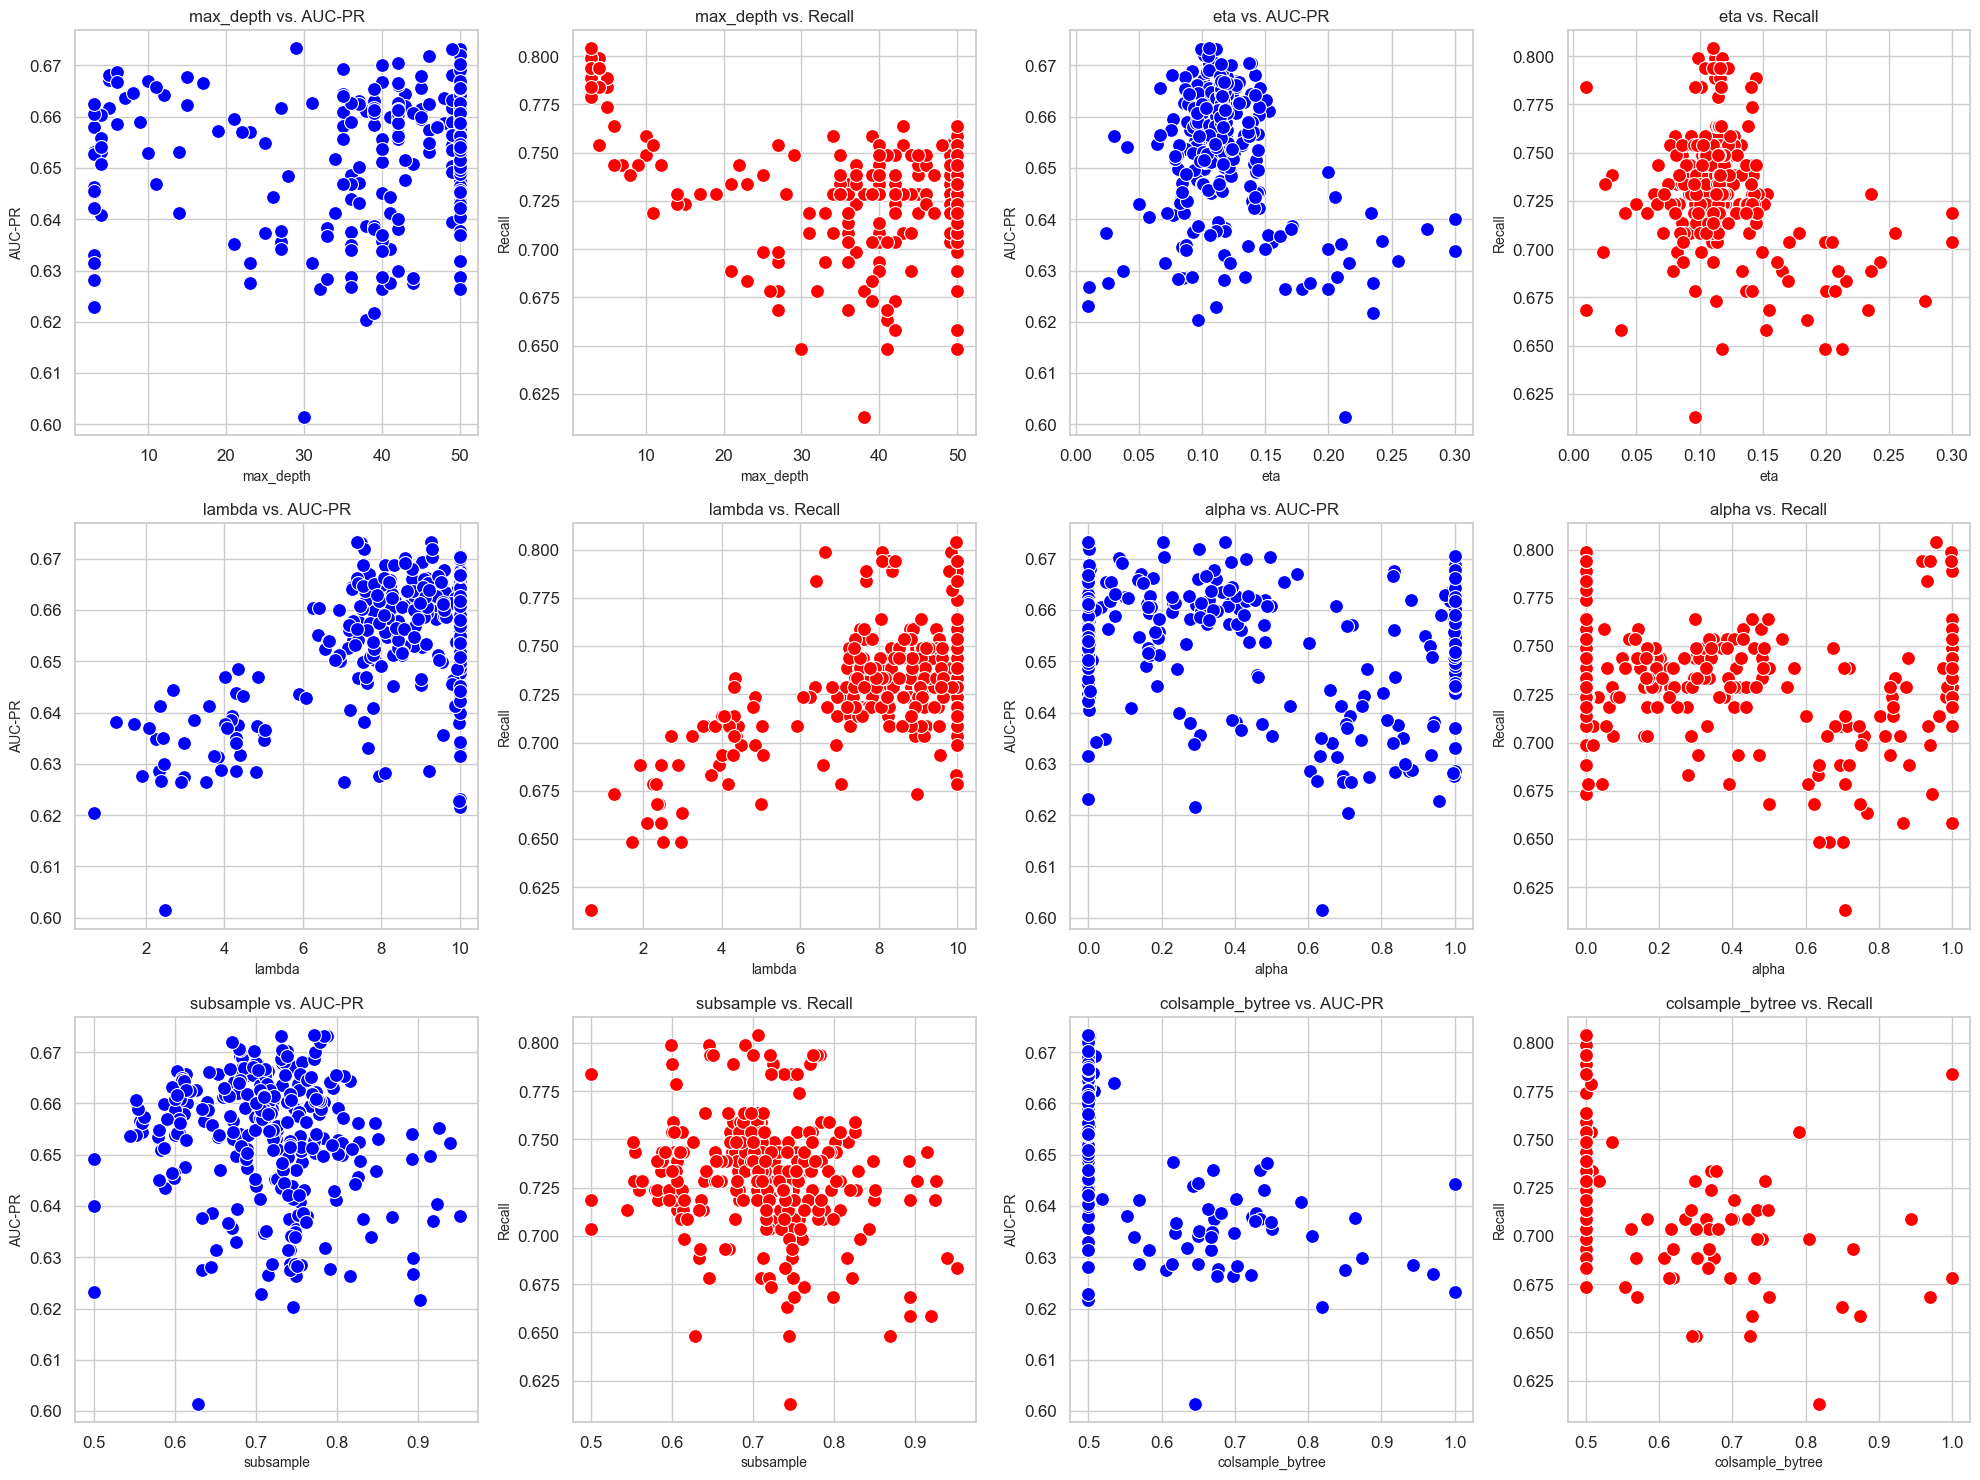

In [18]:
# List of hyperparameters
hyperparameters = ['max_depth', 'eta', 'lambda', 'alpha', 'subsample', 'colsample_bytree']

# Calculate the number of rows needed for subplots (2 plots per hyperparameter, but maintaining 4 plots per row)
n_rows = int(np.ceil(len(hyperparameters) / 2.0))

# Create a figure with subplots - adjusted for correct number of rows and 4 columns per row
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows), dpi=100) 
# Note: Ensuring we have 4 columns in each row, hence '4' is used regardless of hyperparameter combinations

# Flatten the axes array for easy indexing
axes = axes.ravel()

# Loop over each hyperparameter to create a scatter plot
for i, hyperparam in enumerate(hyperparameters):
    # Plot AUC-PR
    sns.scatterplot(ax=axes[i * 2], data=metadata_df, x=hyperparam, y='AUC-PR', color='blue', edgecolor='w', s=100)
    axes[i * 2].set_title(f'{hyperparam} vs. AUC-PR', fontsize=12)
    axes[i * 2].set_xlabel(hyperparam, fontsize=10)
    axes[i * 2].set_ylabel('AUC-PR', fontsize=10)
    
    # Plot Recall
    sns.scatterplot(ax=axes[i * 2 + 1], data=metadata_df, x=hyperparam, y='Recall', color='red', edgecolor='w', s=100)
    axes[i * 2 + 1].set_title(f'{hyperparam} vs. Recall', fontsize=12)
    axes[i * 2 + 1].set_xlabel(hyperparam, fontsize=10)
    axes[i * 2 + 1].set_ylabel('Recall', fontsize=10)

# Adjust layout
plt.tight_layout()

# Hide any excess subplot spaces
for j in range(i * 2 + 2, len(axes)):
    axes[j].set_visible(False)

plt.show()

### Identifying the Optimal XGBoost Model with the Highest AUC-PR

The following process is utilized to identify the XGBoost model hyperparameters that achieved the highest Precision-Recall Area Under Curve (AUC-PR) from a series of model training trials.

The script locates the trial with the highest AUC-PR value from the combined metadata DataFrame, which contains the results from all tuning job trials. 

This printout will display the row from the DataFrame that holds the highest AUC-PR score, providing a clear view of the specific model configuration that led to the best performance.

In [19]:
# Find the index of the row with the highest AUC-PR value
max_auc_pr_index = combined_df['AUC-PR'].idxmax()

# Retrieve the row with the highest AUC-PR value
max_auc_pr_row = combined_df.loc[max_auc_pr_index]

# Print the row
print(max_auc_pr_row)

Unix Time                 1712880847.438826
Confusion Matrix    [[362 143]\n [ 50 149]]
Precision                          0.510274
Recall                             0.748744
Accuracy                           0.725852
F1-Score                           0.606925
AUC-ROC                            0.819722
AUC-PR                             0.673318
max_depth                                29
eta                                0.105418
lambda                             7.377798
alpha                              0.371554
subsample                          0.772195
colsample_bytree                        0.5
TN                                      362
FP                                      143
FN                                       50
TP                                      149
Name: 287, dtype: object


### Locate the Corresponding Model File

Given the model identifier which is attached to each saved model as a Unix timestamp, the corresponding model file in Google Cloud Storage is identified with the following command sequence:

1. **Command Execution**:
   List files in the specific GCS bucket directory and grep for the unique Unix timestamp related to the optimal model. Shell commands are used to interact with Google Cloud Storage:
   
   
```bash
(base) tharindu@192 metadata % gsutil ls gs://telco-churn-prediction/model | grep -i 1712880847
gs://telco-churn-prediction/model/xgboost_model17128808474388263.json
```
   
   `1712880847` is the actual Unix timestamp string captured from the metadata of the highest AUC-PR model, identified in the earlier step.

2. **Output**:
   The command will output the path to the model file. This file is the XGBoost model that has been configured with the optimal hyperparameters for maximum AUC-PR.